In [ ]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import glob, os
from sklearn.linear_model import LogisticRegression
data_dir='./data/'

# Computer Vision for Medical Diagnosis - PatchCamelyon (PCam)

## Our Medical Diagnosis data

### Overview
We are going to be working on PatchCamelyon, a new (2018) and challenging image classification dataset. It consists of 327,680 color images extracted from histopathologic scans of lymph node sections. Each image is annoted with a binary label indicating presence of metastatic tissue.

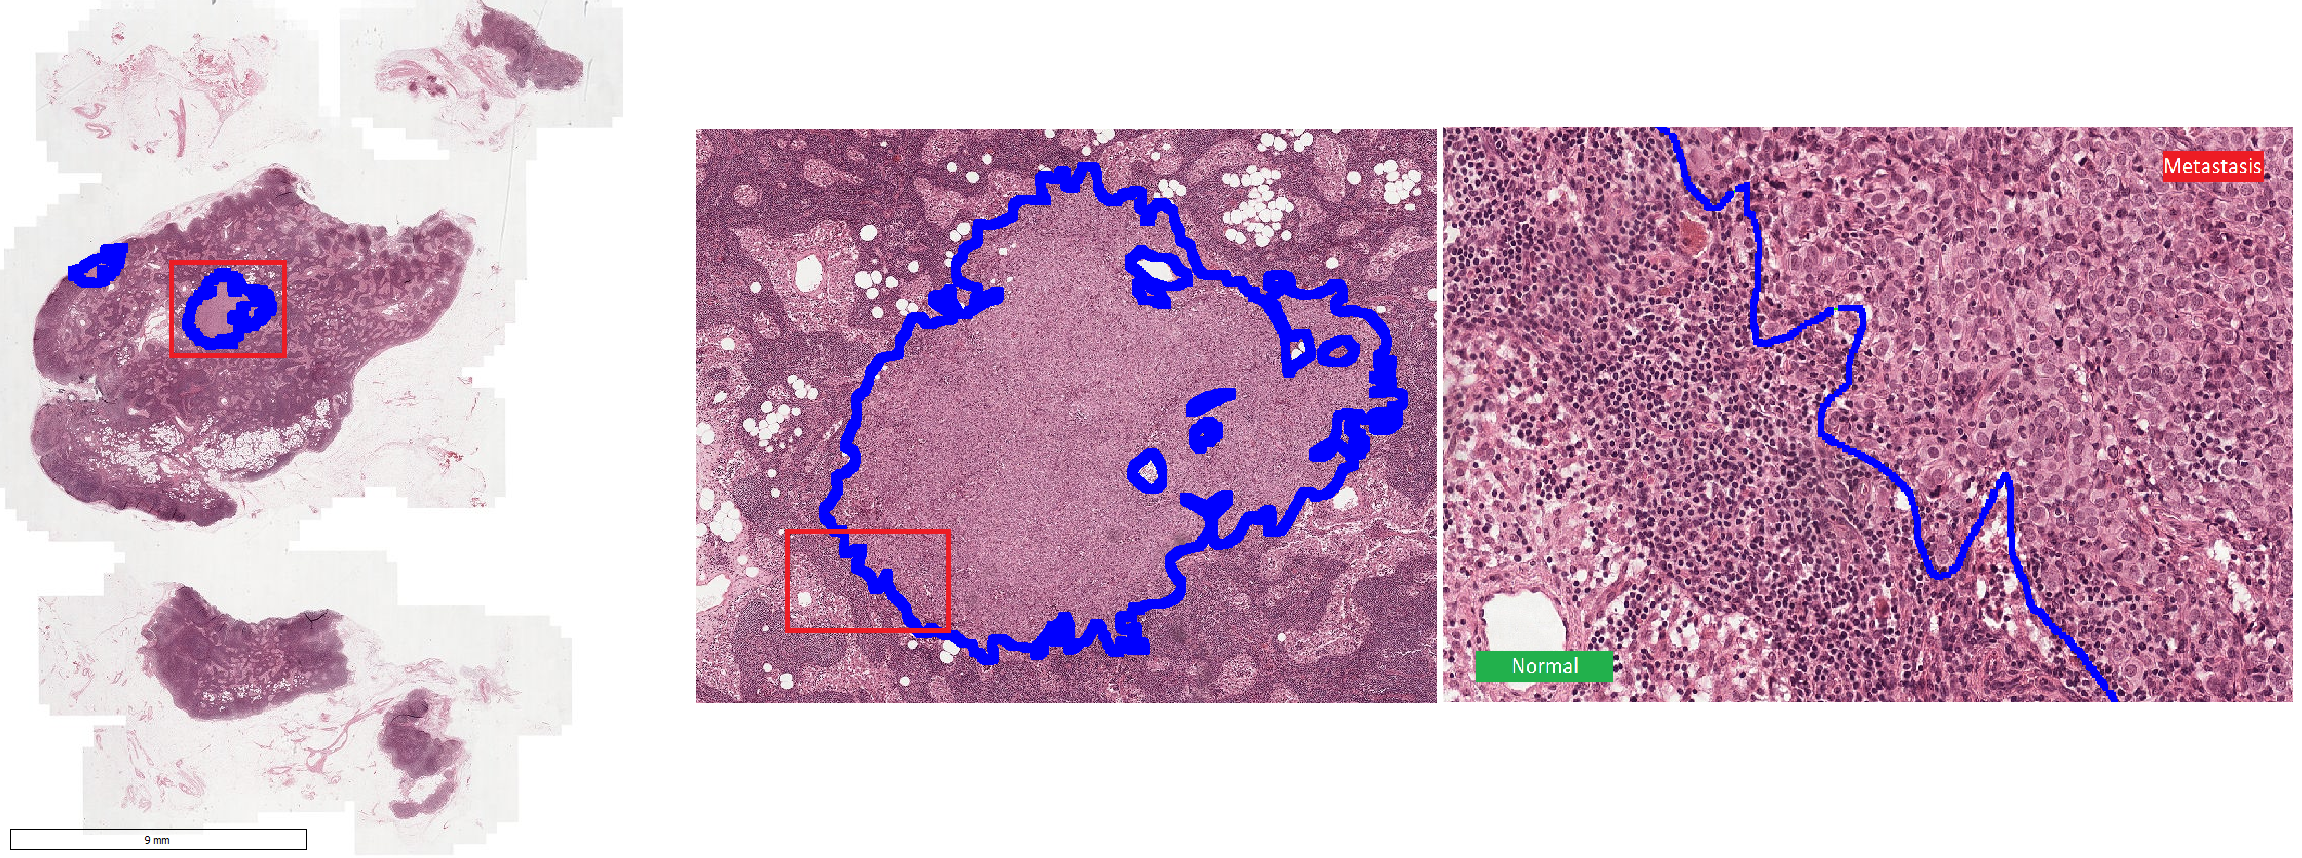
*Example of metastatic region in histopathologic scan*


### Splits
All splits have a 50/50 balance between positive (metastatic tissue) and negative (no metastatic tissue) examples.

| Split | Patches |
|------:|:-------:|
| train | 262,144 |
| valid |  32,768 |
|  test |  32,768 |


### Labeling
A positive (1) label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.

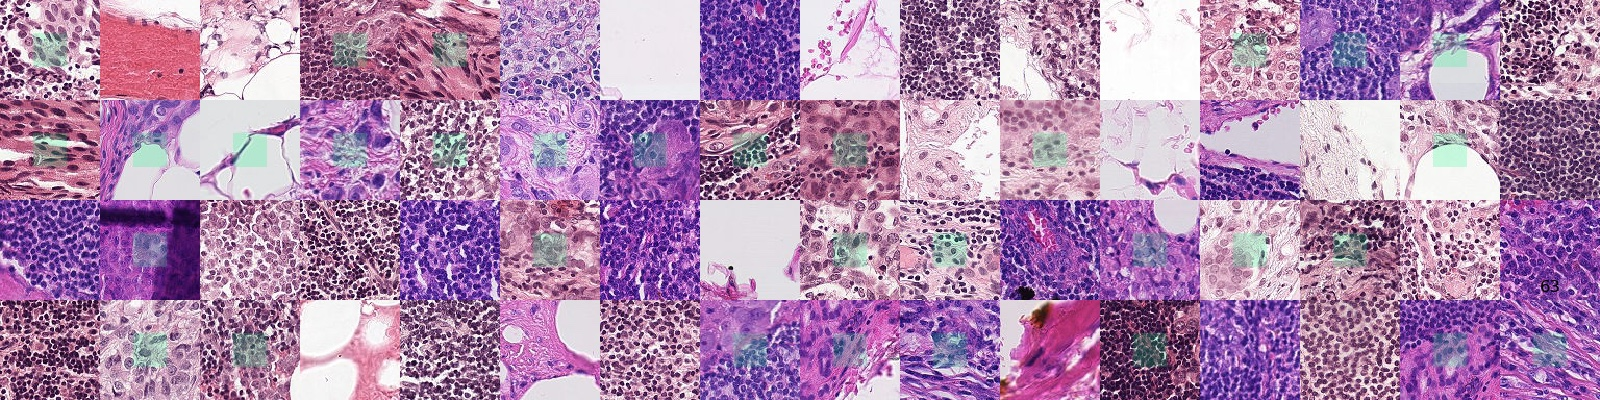
*Example images from PCam. Green boxes indicate a center region which contains at least one pixel of tumor tissue.*

source: https://github.com/basveeling/pcam

### Data organization
We are using 10% of the total data. Our data is organized in the following file structure, where the '0' folder holds examples without metastatic tissue and '1' folder holds examples with metastatic tissue:
```
data
├── train
│   ├── 0
│   └── 1
├── valid
│   ├── 0
│   └── 1
└── test
    ├── 0
    └── 1
```

### Optional: about the image colors 

These tissue samples are made using **H&E staining**. The two stains (H and E) form ionic bonds with different parts of the cell so that we can tell them apart. 

Haematoxylin (<b>H</b>) in complex with aluminium salts is cationic (positively charged). It can react with negatively charged, basophilic cell components, such as nucleic acids in the **nucleus**. These stain **blue** as a result. 

Eosin (<b>E</b>) is anionic (negatively charged). it can react with positively charged, acidophilic components in the tissue, such as amino groups in proteins in the **cytoplasm**. These stain **pink** as a result. 

Without H&E staining, the whole image would be a dull grey color.

source: https://bitesizebio.com/13400/a-beginners-guide-to-haematoxylin-and-eosin-staining/ 

## Working with Images

In computer vision, we turn images or videos into meaningful information about the world. 

When we're programming a computer to create this information, the image is represented as an array of numbers

Load a PCam image with metastatic tissue and print its array values

In [ ]:
image_path1 = data_dir + 'train/1/patch0000001.jpg'

#Load the image
image = io.imread(image_path1);

# Show the image
print("What we see:")
plt.suptitle('PCam patch')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
### YOUR CODE HERE - show the image with plt.imshow(image) ### 

###
plt.show()

# Print the image's numerical representation
print("What the computer sees:\n")
### YOUR CODE HERE - print the image array with print(image) ###

###

Check the image shape by calling `image.shape`

In [2]:
### Your code here - check the image shape ###

####

You should get (96,96,3). 

That is, we have 96 * 96 = 9,216 pixels representing each image.

You can look at these individual pixel values. 

In [ ]:
## Your code here - change x & y to look at different pixel values
x = 
y = 
##

print('[ R G B ]')
print(image[y,x,:])

plt.imshow(image)
plt.scatter(x, y, s=150, facecolors='none', edgecolors='b', linewidth=3)
plt.show()

Lighter pixels have higher values; ratios between the R,G, and B values determine the hue.

Eventually, we want to classify theses images as having metastatic tissue or not, but first we want to simplify these pixels into fewer numerical values or features. 

## Extracting average pixel value as a feature

One way we can try to simplify our data is by averaging all of the pixels for each patch.

###  Reminder: What is an average?

The formula for the average is:

$ avg = \frac{1}{w*h}\sum_{x=1}^w \sum_{y=1}^h p_{x,y}$

Where $p_{x,y}$ is the pixel value at the x,y location, and w and h are width and height respectively.

So, we add up all of the pixel values and divide by the number of pixels

### Using numpy to calculate the average

Luckily, numpy (np) has a function that can perform that calculation for us more quickly: `np.average`

_Hint 1_: If you need help with the `np.average` function, call `help(np.average)` (scroll down in the help for examples). 

_Hint 2_: There is a useful parameter called `axis (type: None, tuple of ints, or ints)` that you can use to select axes to average (we want to average x and y)

_Hint 3_: The axes are 0: y, 1: x,   2: pixel color.

_Hint 4_: To average multiple axes, pass `axis` a `tuple` of the axes numbers like `(0,1)`

In [ ]:
help(np.average)

Define your average pixel function

In [ ]:
def avg_px_val(image):
## Your code here ##
    average = 
#########################
    return average

In [ ]:
# Call your function
average = avg_px_val(image)
# Round average to integer values
average = np.round(average).astype(int)
# Print your solution
print(average)

You should get a length 3 array as output: [191, 160, 183]

If you didn't, double check your axis parameter and ask for help if needed.

Let's see what color the average pixel value is:

In [ ]:
color_patch = np.ones((96,96,3), dtype='int') * average
plt.imshow(color_patch); plt.show()

Repeat this on a different image without metastatic tissue  (from the "0" directory)

In [ ]:
image_path2 = data_dir + 'train/0/patch0000000.jpg'
image2 = io.imread(image_path2)
plt.imshow(image2); plt.show()

Calculate the average pixel value for this patch and display the color patch as we did above (feel free to copy code)

In [ ]:
## Your code here ##
# Call your avg_px_val function on image2
average2 =

# Round the average to integer values
average2 = 

# Create color_patch2
color_patch2 = 

# Show color_patch2 with plt.imshow
plt.imshow(color_patch2); plt.show()
######

### Train a classifier on average pixel value

We can see that the average pixel value is different from the metastatic tissue sample to the nonmetastatic tissue sample, but we don't know if this is true for all of the samples.

So,let's get back to the original task: classifying metastatic tissue.

We are going to see how useful the average pixel value is for classifying tissue by fitting a logistic regression classifier to the average pixel value data.

Load the training patches and calculate the features (average pixel value) for each patch. 

This might take a few seconds, because there are 10k (10,000) training images.

In [ ]:
# Get a list of the files within the directory
train_files_1 = glob.glob(data_dir + 'train/1/*')
train_files_0 = glob.glob(data_dir + 'train/0/*')

# Create labels for the examples
train_y = np.concatenate((np.ones(len(train_files_1)), np.zeros(len(train_files_0))))

# Read the images into train_images
train_images = [io.imread(f) for f in train_files_1+train_files_0]

# Create empty features array (each average pixel value feature is length 3)
avg_train_X = np.empty((len(train_images), 3))
                   
for index, train_image in enumerate(train_images):
    ### Your code here (for calculating the features - call your avg_px_val function on train_image)##
    avg_train_X[index, :] = 

Fit a logistic regression classifier to the training patches by initializing sklearn's `LogisticRegression` and fitting it to our data

hint 1: The default parameters to `LogisticRegression` are okay, so you can initialize `clf` as `LogisticRegression()`

hint 2: Once you define the classifier, you must call its fit function - `.fit(data, labels)` - with our data (`train_X`) and labels (`train_y`) 

In [ ]:
## Your code here ##
# Initialize classifier (LogisticRegression)
avg_clf = 

# Fit classifier to data with avg_clf.fit


# Score on training set with avg_clf.score
avg_train_score = 

####

# Print score on training set
print(avg_train_score)

Load the validation set and calculate the features

In [ ]:
valid_files_1 = glob.glob(data_dir + 'valid/1/*')
valid_files_0 = glob.glob(data_dir + 'valid/0/*')

# Create label array
valid_y = np.concatenate((np.ones(len(valid_files_1)), np.zeros(len(valid_files_0))))

# Read images
valid_images = [io.imread(f) for f in valid_files_1+valid_files_0]

# Create empty array for features
avg_valid_X = np.empty((len(valid_images), 3))
                   
#Calculate features
for index, valid_image in enumerate(valid_images):
    ## Your code here ##
    avg_valid_X[index, :] = 

Calculate the performance of your classifier on the valid patches (valid_X, valid_y) with `clf.score` (Don't fit the classifier to the new data!)

In [ ]:
## Your code here ##
# Score the classifier on the validation split features 
avg_valid_score = 

##
print(avg_valid_score)

Load the test patches and calculate the performance on the test patches following the same procedure as we used for the valid patches

In [ ]:
test_files_1 = glob.glob(data_dir + 'test/1/*')
test_files_0 = glob.glob(data_dir + 'test/0/*')

## Your code here ##
# Create label array 
test_y = 

# Read images
test_images = 

# Create empty array for features
avg_test_X = 

# Calculate features
for index, test_image in enumerate(test_images):
    avg_test_X[index,:] = 
# Score classifier
avg_test_score = 
##
print(avg_test_score)

## Discussion Questions

Give some thought to these questions and type your thoughts or follow-up questions into the box below.

1. What information could the average pixel color capture about these tissue patches given what we know about the image colors?


2. What does the average pixel color *not* tell us about these images?


## Challenge Problem 1

**Challenge**: Using your knowledge of pixels, make an image array with a design of your choice.

Design ideas: vertical strips, red and blue checker board, smiley face

_Hint 1_: Try drawing your design on paper and writing out the pixel values before you create it in code.

_Hint 2_: Take advantage of patterns in your design idea to make your code shorter (symmetry, repetition, etc.)

_Hint 3_: If you google "rgb color picker", you can find the pixel colors more easily

In [ ]:
## Black and white horizontal stripe pattern
my_image = np.zeros((10,10))
for i in range(0,10,2):
    my_image[i,:] = 1
        
plt.imshow(my_image, cmap='gray'); plt.show()


In [ ]:
## Yellow and Blue M design

my_image = np.ones((10,10,3)) * [255, 255, 0]  #yellow bg

m_pattern = np.zeros((10,10))
m_pattern[1:9, 1:2] = 1
m_pattern[1:9, 8:9] = 1
m_pattern[1:2, 0:3] = 1
m_pattern[8:9, 0:3] = 1
m_pattern[1:2, 7:10] = 1
m_pattern[8:9, 7:10] = 1
m_pattern[3,4] = 1
m_pattern[2,3] = 1
m_pattern[3,5] = 1
m_pattern[2,6] = 1

my_image[m_pattern==1] = [0,0, 255]

plt.imshow(my_image); plt.show()


In [ ]:
### Your code here - make your own design ###


##

## Challenge problem 2

Challenge: Edit an image from the web with color replacement.

### Example

Find a cartoon image from the web and copy its URL here (images with solid blocks of color will work better)

In [ ]:
url = "https://logoeps.com/wp-content/uploads/2013/08/coca-cola-3-products-vector-logo.png"

Read in the image & process alpha channels if necessary

In [ ]:
%matplotlib inline
# Read in image
image = io.imread(url)
if image.shape[2] > 3:
    #Replace alpha matting w/ white pixels and remove
    image[image[:,:,3] == 0] = [255,255,255,255]
    image = image[:,:,0:3]

plt.imshow(image)

Now select a pixel color from your image and replace it with another pixel color

In [ ]:
# Select pixel or a color
sprite_green = image[320, 320]

replacement_blue = [0, 0, 255]
image[np.where(np.all(image == sprite_green, axis=-1))] = replacement_blue
plt.imshow(image); plt.show()

### Your color replacement

## Extra hard challenge problem (no help given)

Try and come up with another image effect and apply it to your own image (with no libraries except numpy!)

Examples: Rotate the image, crop the image, color tinting, image lightening/darkening, add shape stamps on top of image, etc.

Feel free to use google to get ideas, work together with the rest of the team, or ask for help.

In [ ]:
### Your code here ###
url = ""
image = io.imread(url)

# Edit the image

#########